# Setup the Code

In [1]:
"""
Import Packages
"""

import numpy as np
import cvxpy as cp
import seaborn as sns
from scipy import stats, optimize
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import scipy
from typing import Union
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import numpy.ma as ma
import math
import statsmodels.api as sm
import matplotlib.ticker as mtick
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from dateutil.relativedelta import relativedelta
import yfinance as yf
from multiprocessing import Pool

In [ ]:
"""
Download data created in Pyhton
"""

# create a numpy array
nparray = returns

# Saving the array
np.savetxt("returns.csv", nparray, delimiter=",")

# Reading the csv into an array
firstarray = np.genfromtxt("returns.csv", delimiter=",")

In [2]:
"""
Download Relevant Data
"""

ticker_symbols = ['LCUW.DE','SXRT.DE','5ESG.F','WTDM.DE']


In [3]:
"""
Process Data
"""

# Create an empty dictionary to store the ETF data
etf_prices = {}

# Loop through each ticker symbol
for symbol in ticker_symbols:
        # Retrieve the ETF data from Yahoo Finance
        etf_prices[symbol] = yf.download(symbol)

# Process the retrieved data as needed
etf_closing_prices = {}
 
for symbol, data in etf_prices.items():
      
    etf_closing_prices[symbol] = data["Close"]

# Create a DataFrame from the closing prices dictionary
prices = pd.DataFrame(etf_closing_prices)

# Set the index to be the date
prices.index = prices.index.date

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
"""
Fill NaN 
"""

prices = prices.fillna(method='ffill')
prices

,LCUW.DE,SXRT.DE,5ESG.F,WTDM.DE
2010-03-11,NaN,66.730003,NaN,NaN
2010-03-12,NaN,66.800003,NaN,NaN
2010-03-15,NaN,66.169998,NaN,NaN
2010-03-16,NaN,67.019997,NaN,NaN
2010-03-17,NaN,67.529999,NaN,NaN
...,...,...,...,...
2023-06-05,13.9090,153.360001,54.330002,33.959999
2023-06-06,13.9355,153.619995,54.119999,33.799999
2023-06-07,13.8985,153.520004,54.220001,33.820000
2023-06-08,13.8265,153.639999,53.900002,33.660000


In [5]:
"""
Calculate Returns
"""

returns = prices.pct_change()
returns = returns.dropna(axis=0)

In [6]:
# colors for factors

cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, len(returns.columns)))

In [7]:
"""
Define Inputs
"""

# number of periods
num_periods = len(returns)

# number of factors
num_assets = len(returns.columns)

# window size 
window_size = 252

# effective number of periods
eff_num_periods = num_periods - window_size

# equally weighted portfolio
w_eq = np.repeat(1.0 / num_assets, num_assets)
weights_eq = np.array(w_eq).astype(float)

In [8]:
"""
Define Functions
"""

# Portfolio Variance
def calculate_portfolio_variance(weights: np.ndarray, cov_mat: np.ndarray) -> float:
    return weights @ cov_mat @ weights

# Portfolio Standard Deviation
def calculate_portfolio_std(weights: np.ndarray, cov_mat: np.ndarray) -> float:
    return np.sqrt(calculate_portfolio_variance(weights, cov_mat))

# Covariance to Correlation Matrix
def cov_to_corr_matrix(cov_mat):
    vols = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / np.outer(vols, vols)
    corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1 # numerical error 
    return corr_mat

# Lasse Heje Shrinkage Method
def shrunk_cov_mat(returns: np.ndarray, shrinkage_param: float = 0.5) -> np.ndarray:
    returns_df = pd.DataFrame(returns)
    corr_matrix = returns_df.corr()
    vol_vec = np.sqrt(np.diag(returns_df.cov()))
    shrinked_corr = corr_matrix * (1 - shrinkage_param) + np.identity(len(corr_matrix)) * shrinkage_param
    return np.outer(vol_vec, vol_vec) * shrinked_corr

# Most Diversified Portfolio

In [9]:
"""
Define Functions
"""

# Define Diversification Ratio
def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):
    port_std = calculate_portfolio_std(weights=weights, cov_mat=cov_mat)
    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)
    return avg_std / port_std

# Define Optimization Problem
def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    # Define the number of assets
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)

    # Define the sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Set the bounds for optimization (0% to 100%)
    bounds = [(0, 1)] * n

    # Perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat), init_weights,
                            constraints=eq_constraint, bounds=bounds)

    return res.x

In [10]:
"""
Perform calculations for MDP with monthly rebalancing 
"""

most_div_port_weights_monthly_epo = np.zeros((eff_num_periods, num_assets))
most_div_port_cc_monthly_epo = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    if t % 121 == 0:  # rebalance every 21 periods (monthly)
        
        # calculate returns for the past 21 periods (month)
        returns_subset = returns.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        most_div_port_weights_monthly_epo[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_monthly_epo[t] = calculate_cc_ratio(most_div_port_weights_monthly_epo[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_monthly_epo[t, :] = most_div_port_weights_monthly_epo[t-1, :]
        most_div_port_cc_monthly_epo[t] = most_div_port_cc_monthly_epo[t-1]

# store in data-frame
df_most_div_port_weights_monthly_epo = pd.DataFrame(data=most_div_port_weights_monthly_epo,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

In [11]:
df_most_div_port_weights_monthly_epo[-5:]

,LCUW.DE,SXRT.DE,5ESG.F,WTDM.DE
2023-06-05,0.199632,0.244238,0.277575,0.278555
2023-06-06,0.199632,0.244238,0.277575,0.278555
2023-06-07,0.199632,0.244238,0.277575,0.278555
2023-06-08,0.199632,0.244238,0.277575,0.278555
2023-06-09,0.199632,0.244238,0.277575,0.278555


/var/folders/fs/rz1t0hzs0rsdwyxsl8hr4rtc0000gn/T/ipykernel_49668/2142363599.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(returns.columns, rotation=55)


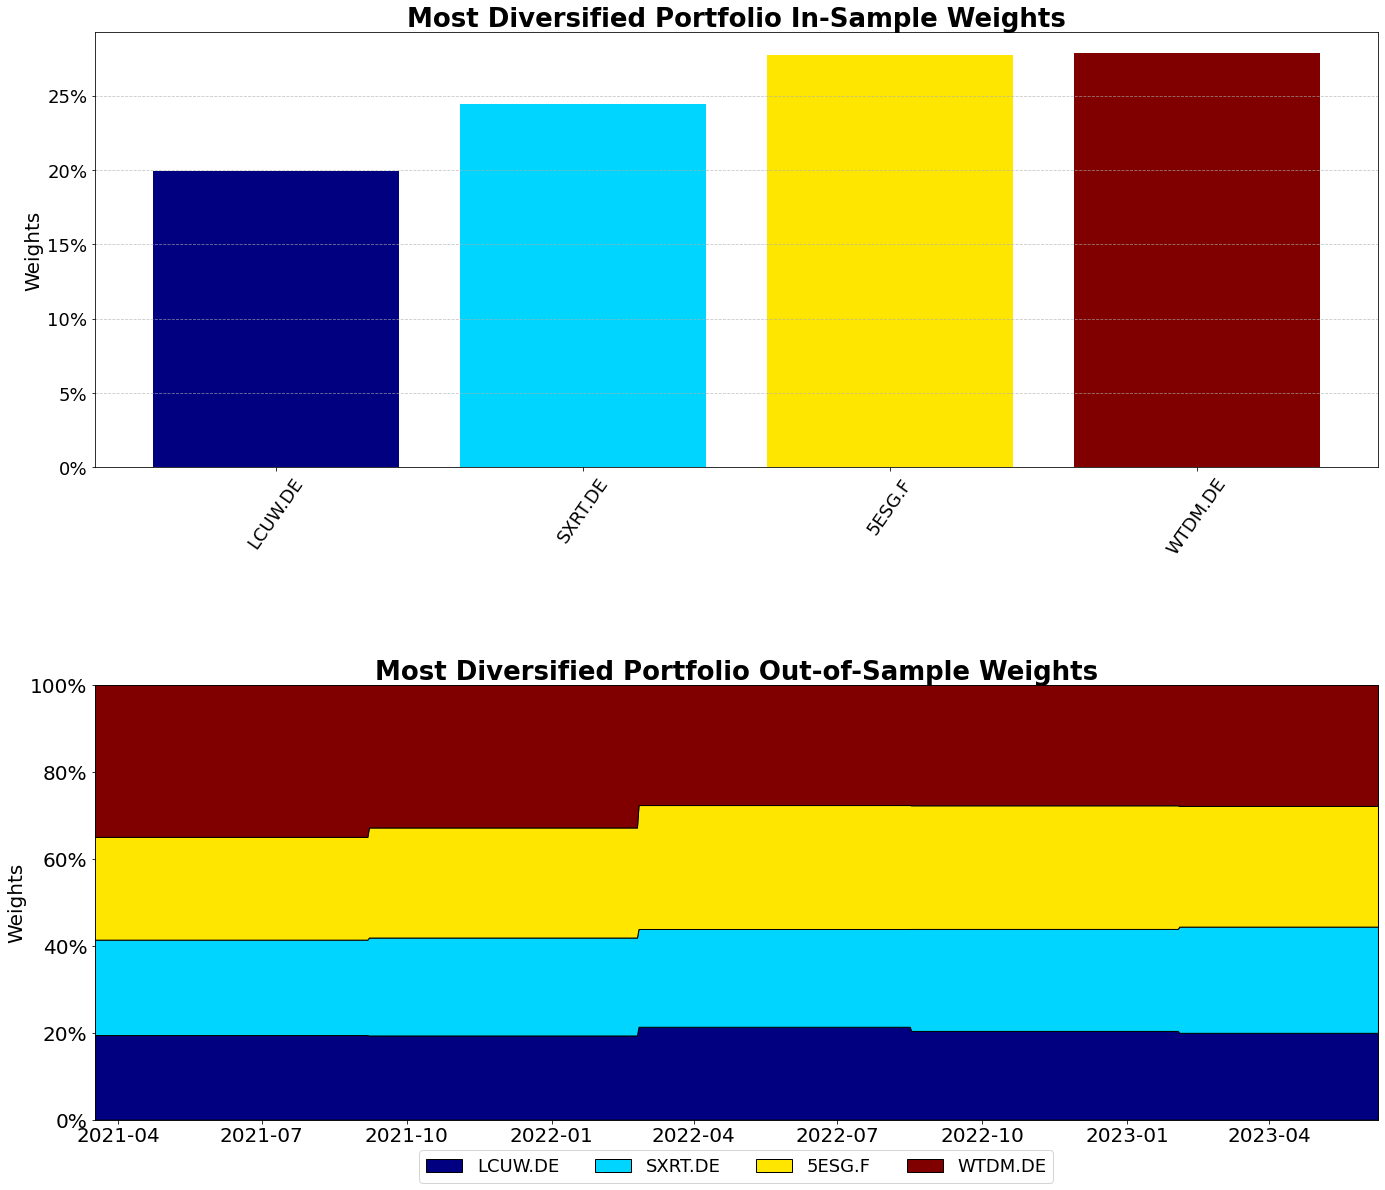

In [12]:

mdp_in = calculate_most_diversified_portfolio(cov_mat)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(23, 20))

# Plot 1: Average Holdings in Most Diversified Portfolio
ax1.bar(returns.columns, mdp_in, color=ind_colors)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylabel('Weights', fontsize=20)
ax1.set_title('Most Diversified Portfolio In-Sample Weights', fontsize=26, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax1.set_xticklabels(returns.columns, rotation=55)

# Plot 2: MDP Weights Monthly Rebalancing
ax2.stackplot(returns.index[window_size:], most_div_port_weights_monthly_epo.T,
              edgecolor="black", labels=returns.columns, colors=ind_colors)
ax2.set_ylabel('Weights', fontsize=20)
ax2.set_title("Most Diversified Portfolio Out-of-Sample Weights", fontsize=26, fontweight='bold')
ax2.set_xlim(returns.index[window_size], returns.index[-1])
ax2.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=18, loc='upper center')
ax2.set_ylim(0,1)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax2.tick_params(axis='both', labelsize=20)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


# Tangency

In [13]:
def tangency_portfolio(cov_mat: np.ndarray, returns: np.ndarray, rf: float) -> np.ndarray:
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)
    mu = np.mean(returns, axis=0)
    excess_mu = mu - vec_ones * rf
    cov_mat_inv = np.linalg.inv(cov_mat)

    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # define no shorting constraint
    bounds = [(0, None) for i in range(num_assets)]
    
    # define sharpe ratio
    def neg_sharpe_ratio(weights, excess_mu, cov_mat_inv):
        p_return = np.dot(excess_mu, weights)
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
        return -(p_return / p_volatility)

    result = optimize.minimize(neg_sharpe_ratio, np.repeat(1.0 / num_assets, num_assets), 
                               args=(excess_mu, cov_mat_inv), method='SLSQP', bounds=bounds, constraints=eq_constraint)
    
    w_max_sr = result.x
    
    return w_max_sr

In [14]:
""" 
Perform calculations for tangency portfolio with monthly rebalancing
"""

mean_var_port_weights_monthly = np.zeros((eff_num_periods, num_assets))
mean_var_port_cc_monthly = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    if t % 121 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        mean_var_port_weights_monthly[t, :] = tangency_portfolio(cov_mat, returns, 0)
        mean_var_port_cc_monthly[t] = calculate_cc_ratio(mean_var_port_weights_monthly[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        mean_var_port_weights_monthly[t, :] = mean_var_port_weights_monthly[t-1, :]
        mean_var_port_cc_monthly[t] = mean_var_port_cc_monthly[t-1]

# store in data-frame
df_mean_var_port_weights_monthly = pd.DataFrame(data=mean_var_port_weights_monthly,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

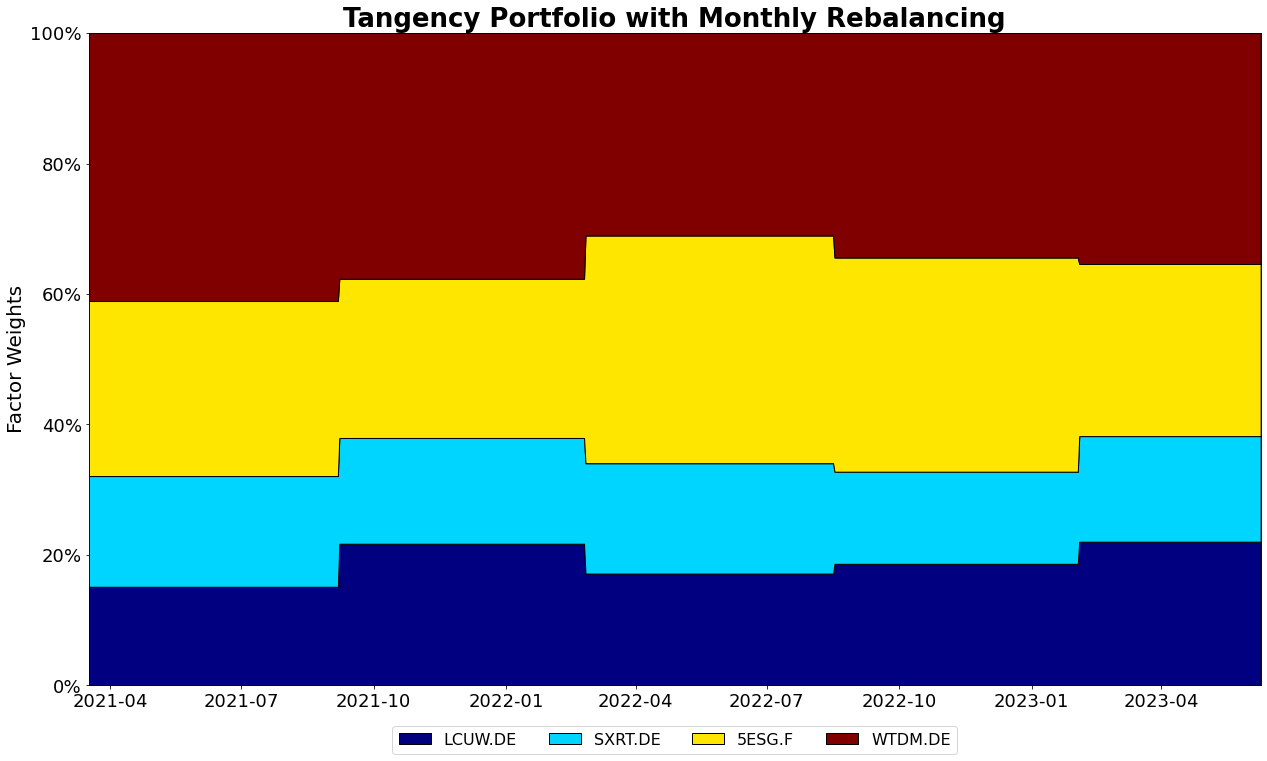

In [15]:
""" 
Plot Mean-Variance Weights with monthly rebalancing 
"""

fig, ax = plt.subplots(figsize=(21, 12))

ax.stackplot(returns.index[window_size:],
              mean_var_port_weights_monthly.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor Weights', fontsize=20)
ax.set_title("Tangency Portfolio with Monthly Rebalancing", fontsize=26, fontweight='bold');
ax.set_ylim(0,1)
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
# Increase font size of x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=18)

# Set y-axis tick format to percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Out-Of-Sample Performance

In [16]:
df_port_ret = pd.DataFrame(index=returns.index[window_size:])

# Combine portfolios
df_port_ret['Most Diversified'] = (returns[window_size:] * df_most_div_port_weights_monthly_epo).sum(axis=1)
df_port_ret['Tangency'] = (returns[window_size:] * df_mean_var_port_weights_monthly).sum(axis=1)
df_port_ret['Equally Weighted'] = (returns[window_size:] * w_eq).sum(axis=1)

# Calculate cumulative return
df_port_tri = (1 + df_port_ret).cumprod(axis=0) # probably not the correct way
df_port_cum = df_port_ret.cumsum(axis=0) # Only okay for plotting cumulative returns
df_port_cum

,Most Diversified,Tangency,Equally Weighted
2021-03-17,-0.001466,-0.001247,-0.001456
2021-03-18,-0.002810,-0.003400,-0.002608
2021-03-19,-0.007519,-0.007497,-0.007738
2021-03-22,-0.004776,-0.004592,-0.005008
2021-03-23,-0.001490,-0.000822,-0.002391
...,...,...,...
2023-06-05,0.253649,0.250673,0.247330
2023-06-06,0.252059,0.248680,0.246086
2023-06-07,0.252047,0.248687,0.245869
2023-06-08,0.248248,0.244440,0.242112


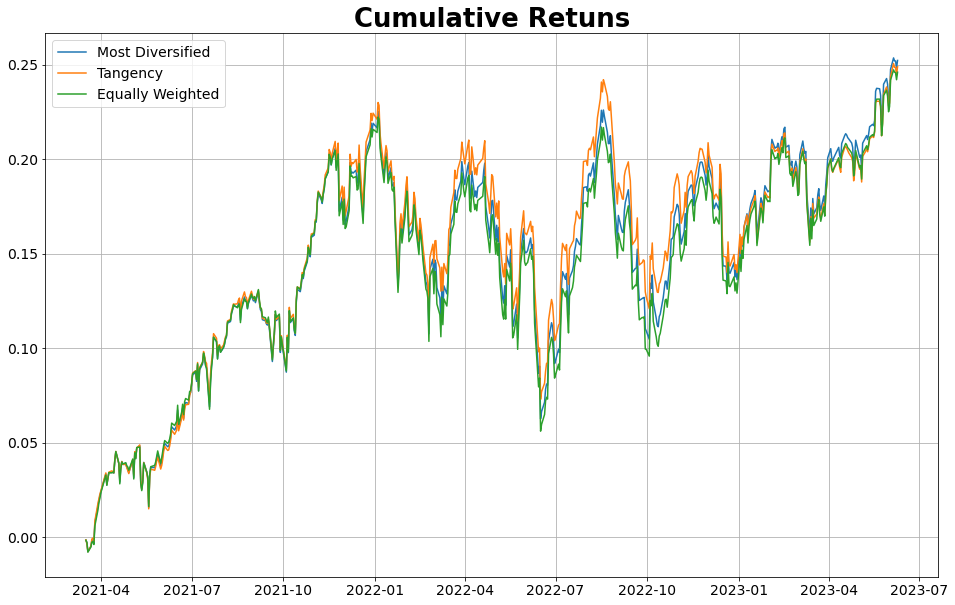

In [17]:
"""
Plot Cumulative Returns
"""

ax = df_port_cum.plot(xlabel="", figsize=(16, 10), grid='True');

# Add legend
ax.legend(fontsize=14)

ax.set_title("Cumulative Retuns", fontweight="bold", fontsize=26)

# Increase font size of x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=18)

# Set font size of ticks
ax.tick_params(labelsize=14)

In [18]:
"""
Perfromance Evaluation
"""

df_port_ret.index = pd.to_datetime(df_port_ret.index)

# Transform daily returns to monthly
df_port_ret_monthly = (1 + df_port_ret).resample('Y').prod() - 1

# Compute Mean
mean_return = df_port_ret_monthly.mean(axis=0)
mean_return.name = "Mean Return"

# Compute Standard Deviation
std_return = df_port_ret_monthly.std(axis=0)
std_return.name = "Standard Deviation"

# Compute Sharpe Ratio
sharpe_ratio = (mean_return / std_return)
sharpe_ratio.name = "Sharpe Ratio"

# Combine the results into a DataFrame
result_df = pd.concat([mean_return, std_return, sharpe_ratio], axis=1)

# Print the results
print("Monthly Portfolio Returns:")
print(df_port_ret_monthly.round(4))
print("\nPerformance Metrics using factor themes:")
print(result_df.round(4))

Monthly Portfolio Returns:
            Most Diversified  Tangency  Equally Weighted
2021-12-31            0.2380    0.2447            0.2338
2022-12-31           -0.0926   -0.0938           -0.0964
2023-12-31            0.1190    0.1111            0.1200

Performance Metrics using factor themes:
                  Mean Return  Standard Deviation  Sharpe Ratio
Most Diversified       0.0881              0.1674        0.5264
Tangency               0.0874              0.1705        0.5124
Equally Weighted       0.0858              0.1678        0.5115


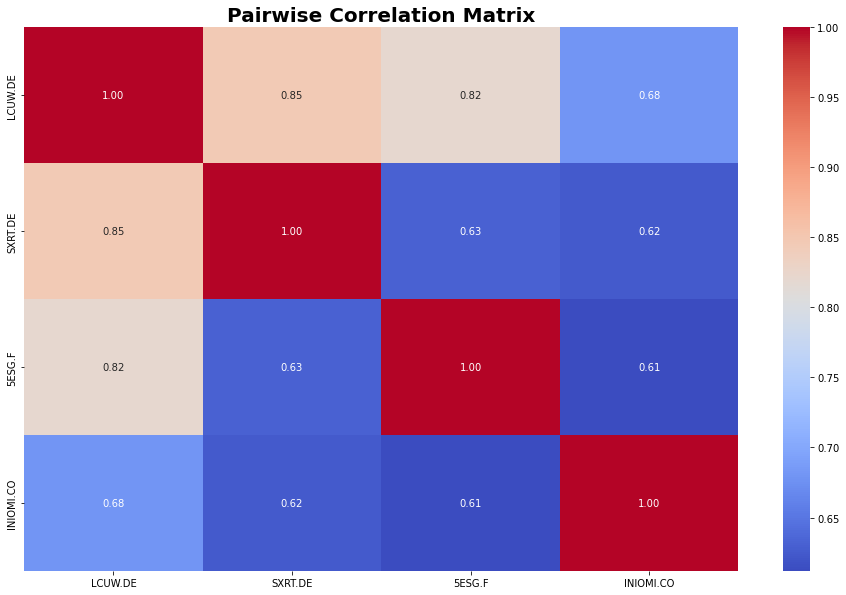

In [524]:
corr_matrix = pd.DataFrame(returns).corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 10))

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Pairwise Correlation Matrix', fontweight='bold', fontsize=20)
plt.show()

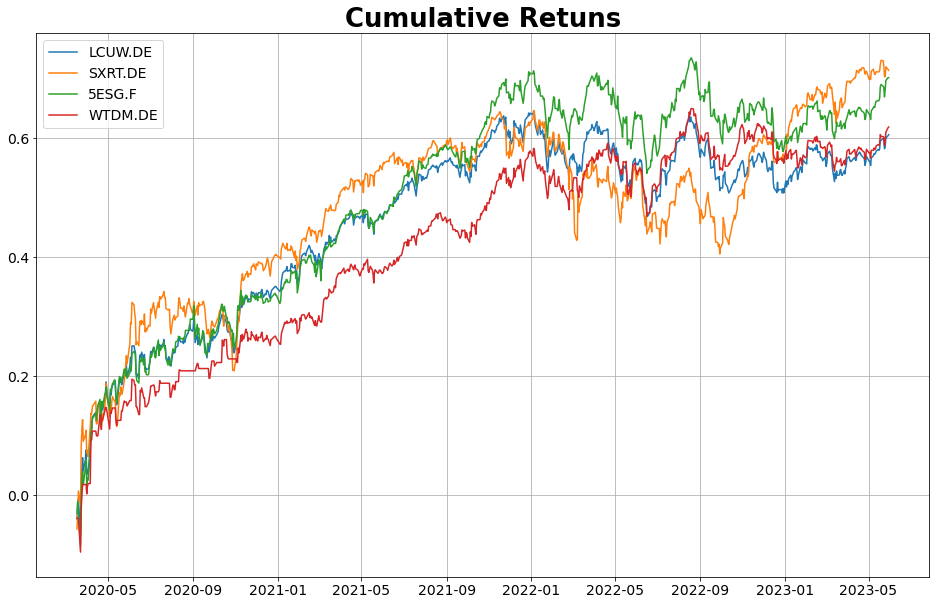

In [506]:
"""
Plot Cumulative Returns For Funds
"""

ret_cum = returns.cumsum(axis=0)

ax = ret_cum.plot(xlabel="", figsize=(16, 10), grid='True');

# Add legend
ax.legend(fontsize=14)

ax.set_title("Cumulative Retuns", fontweight="bold", fontsize=26)

# Increase font size of x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=18)

# Set font size of ticks
ax.tick_params(labelsize=14)